In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os import makedirs
from os.path import join, exists
from nilearn.plotting import plot_connectome, plot_roi, find_parcellation_cut_coords
import bct
import datetime
from nilearn.mass_univariate import permuted_ols
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

sns.set(context='poster', style='ticks')

In [2]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])
grays = sns.light_palette('#999999', n_colors=3, reverse=True)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

In [3]:
def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']
#subjects = ['101', '102', '103']

sink_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output'
fig_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/figures/'

shen = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
shen_coord = find_parcellation_cut_coords(labels_img=shen)
craddock = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'
crad_coord = find_parcellation_cut_coords(labels_img=craddock)
masks = {'shen2015': {'mask': shen,
                      'coordinates': shen_coord}, 
         'craddock2012':  {'mask': craddock,
                           'coordinates': crad_coord}}

tasks = {'retr': [{'conditions': ['Physics', 'General']},
                  {'runs': [0,1]}], 
         'fci': [{'conditions': ['Physics', 'NonPhysics']},
                  {'runs': [0,1,2]}]}

sessions = [0,1]
sesh = ['pre', 'post']
conds = ['high-level', 'lower-level']

index = pd.MultiIndex.from_product([subjects, sessions, tasks, conds, masks], 
                                   names=['subject', 'session', 'task', 'condition', 'mask'])

In [5]:
data_dir = '/Users/kbottenh/Dropbox/Projects/physics-retrieval/data'
b_df = pd.read_csv(join(data_dir, 'rescored', 'non-brain-data.csv'), index_col=0, header=0)


In [6]:
head_size = pd.read_csv(join(data_dir, 'head-size_2019-05-29 15:19:53.287525.csv'), index_col=0, header=0)
head_size['normalized head size'] = (head_size['average_head_size']-np.mean(head_size['average_head_size']))/np.std(head_size['average_head_size'])

In [7]:
fd = pd.read_csv(join(data_dir,'avg-fd-per-condition-per-run_2019-05-29.csv'), index_col=0, header=0)
fd['normalized fd'] = (fd['average fd']-np.mean(fd['average fd']))/np.std(fd['average fd'])
retr_fd = fd[fd['task'] == 'retr']
fci_fd = fd[fd['task'] == 'fci']

df_pivot = retr_fd[retr_fd['condition'] == 'high-level'].reset_index()
retr_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_phys_fd.rename({'pre': 'pre phys retr fd', 'post': 'post phys retr fd'}, axis=1, inplace=True)

df_pivot = retr_fd[retr_fd['condition'] == 'lower-level'].reset_index()
retr_genr_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_genr_fd.rename({'pre': 'pre gen retr fd', 'post': 'post gen retr fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'high-level'].reset_index()
fci_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_phys_fd.rename({'pre': 'pre phys fci fd', 'post': 'post phys fci fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'lower-level'].reset_index()
fci_ctrl_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_ctrl_fd.rename({'pre': 'pre ctrl fci fd', 'post': 'post ctrl fci fd'}, axis=1, inplace=True)

In [8]:
iqs = ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']

In [9]:
big_df = pd.concat([b_df, retr_phys_fd, retr_genr_fd, fci_phys_fd, fci_ctrl_fd], axis=1)

## Running regressions for task+condition whose accuracy was related to IQ
We'll run the permuted OLS regressions with few permutations for a first pass look at how brain connectivity explains variance in different subscores of the WAIS. Significant regressions at this step will be re-run later with more permutations, for more accurate <i>p</i>- and <i>t</i>-values. This is a more efficient use of computational resources than running all possible regressions with many permutations right off the bat.

In [10]:
nodes = list(np.arange(1,269,dtype=int))
index = []
for node1 in nodes:
    for node2 in nodes:
        if node1 > node2:
            index.append((node1, node2))

In [11]:
#read in every person's connectivity matrix (yikes)
#one task & condition at a time, I think. otherwise it becomes a memory issue
np.arange(0,)
index = pd.MultiIndex.from_product([nodes, nodes])
conn_df = pd.DataFrame(columns=index)
mask = 'shen2015'
for subject in subjects:
    try:
        corrmat = np.genfromtxt(join(sink_dir, '{0}-session-1_retr-Physics_{1}-corrmat.csv'.format(subject, mask)),
                                delimiter=' ')
        np.fill_diagonal(corrmat, 0)
        zmat = np.arctanh(corrmat)
        corrs = pd.DataFrame(zmat, index=nodes, columns=nodes)
        #this is c-ordering
        for node1 in nodes:
            for node2 in nodes:
                if node1 > node2:
                    conn_df.at[subject,(node1,node2)] = corrs.loc[node1][node2]
        #conn_df.at[subject] = np.ravel(zmat, order='F')
    except Exception as e:
        print(subject, e)
#fortran ordering does first index changing fastest, last changing slowest
#c-ordering does first changing slowest, last changing fastest
conn_df.dropna(how='all', axis=1, inplace=True)

213 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/213-session-1_retr-Physics_shen2015-corrmat.csv not found.
217 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/217-session-1_retr-Physics_shen2015-corrmat.csv not found.
322 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/322-session-1_retr-Physics_shen2015-corrmat.csv not found.
329 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/329-session-1_retr-Physics_shen2015-corrmat.csv not found.
332 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/332-session-1_retr-Physics_shen2015-corrmat.csv not found.
452 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/452-session-1_retr-Physics_shen2015-corrmat.csv not found.
456 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/456-session-1_retr-Physics_shen2015-corrmat.csv not found.
457 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/457-session-1_retr-Physics_shen2015-corrmat.csv not

In [12]:
big_df.index= big_df.index.astype(int)
conn_df.index = conn_df.index.astype(int)
conn_df = conn_df.astype('float')

conn_df.dropna(how='all', axis=1, inplace=True)
conns = list(set(conn_df.columns))

all_data = pd.concat([big_df, conn_df], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

for column in conn_df.columns:
    if column[0] == column[1]:
        #print(column)
        conn_df.drop(column, axis=1, inplace=True)
conns = list(set(conn_df.columns))

In [13]:
effs = {'post phys fci':['deltaPRI', 'deltaFSIQ'],
        'post phys retr': ['WMI2', 'VCI2']}
iqs = effs['post phys fci'] + effs['post phys retr']
variables = ['iq', 'iqXsex', 'iqXclass', 'iqXsexXclass', 'sexXclass', 'F', 'Mod', 'Age', 'Strt.Level', 'fd']

sig = {}
nodaleff_sig = pd.DataFrame(index=conns)
index = pd.MultiIndex.from_product([iqs, effs.keys(), variables])
retr_params = pd.DataFrame(index=index, columns=['max nlog(p)', 'max t', 'edges'])

WMI2 WMI2 max nlog(p) 0.8936577518833586
# significant edges: 0
WMI2 WMI2XSex max nlog(p) 0.17739349236092583
# significant edges: 0
WMI2 WMI2XClass max nlog(p) 0.6870005011620736
# significant edges: 0
WMI2 WMI2XClassXSex max nlog(p) 0.2882180199040156
# significant edges: 0
WMI2 F max nlog(p) 0.05836361536314618
# significant edges: 0
WMI2 Strt.Level max nlog(p) 2.3988077302032647
# significant edges: 98
WMI2 SexXClass max nlog(p) 0.13398990719372808
# significant edges: 0
WMI2 Age max nlog(p) 2.0977777345392834
# significant edges: 2091
WMI2 Mod max nlog(p) 0.42108412491441677
# significant edges: 0
WMI2 post phys retr fd max nlog(p) 1.2848643778964277
# significant edges: 0
VCI2 VCI2 max nlog(p) 0.351532862819085
# significant edges: 0
VCI2 VCI2XSex max nlog(p) 0.1734984484774017
# significant edges: 0
VCI2 VCI2XClass max nlog(p) 0.3633779920187162
# significant edges: 0
VCI2 VCI2XClassXSex max nlog(p) 0.48499387781954784
# significant edges: 0
VCI2 F max nlog(p) 0.0351957503111201

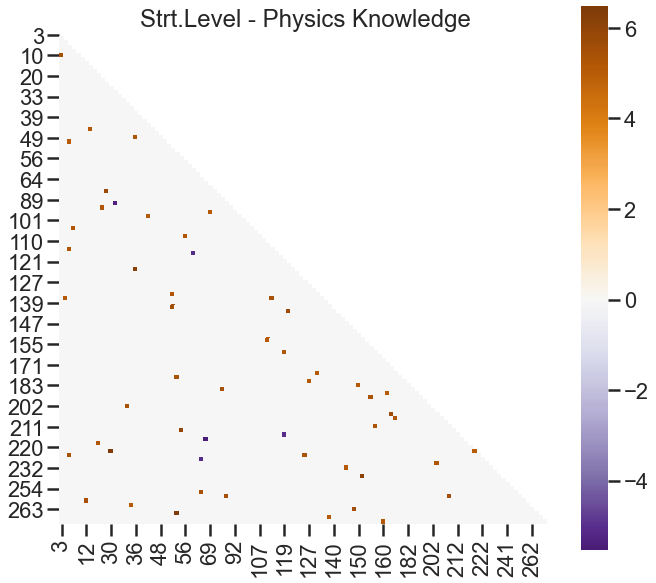

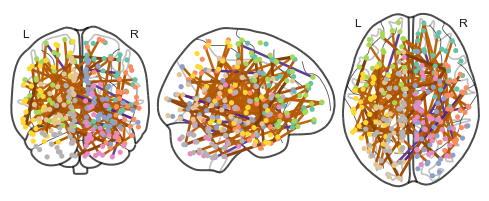

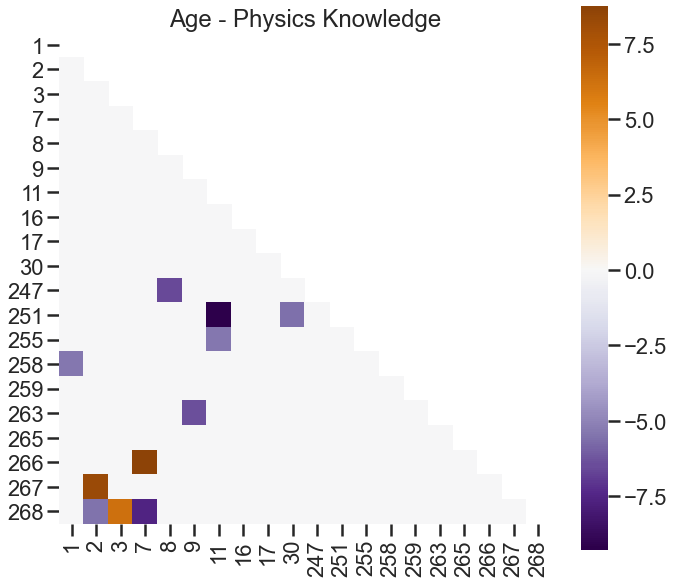

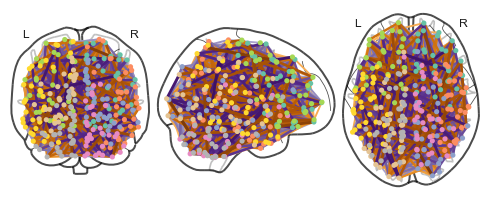

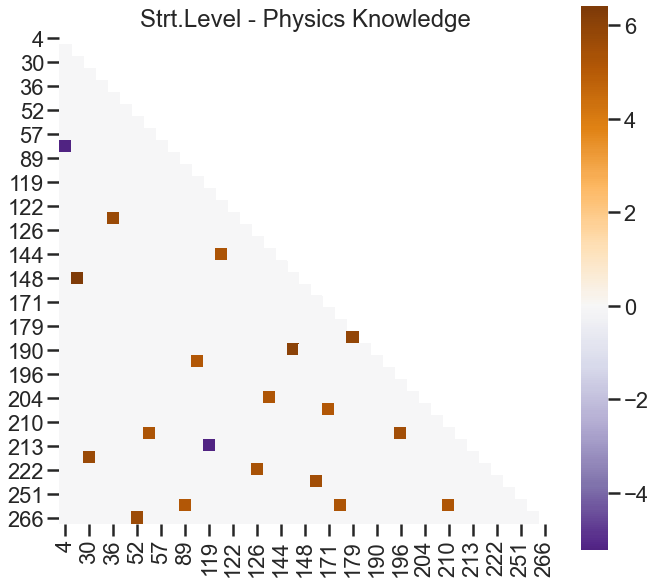

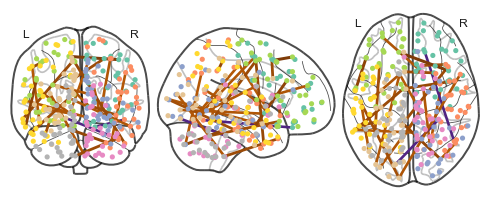

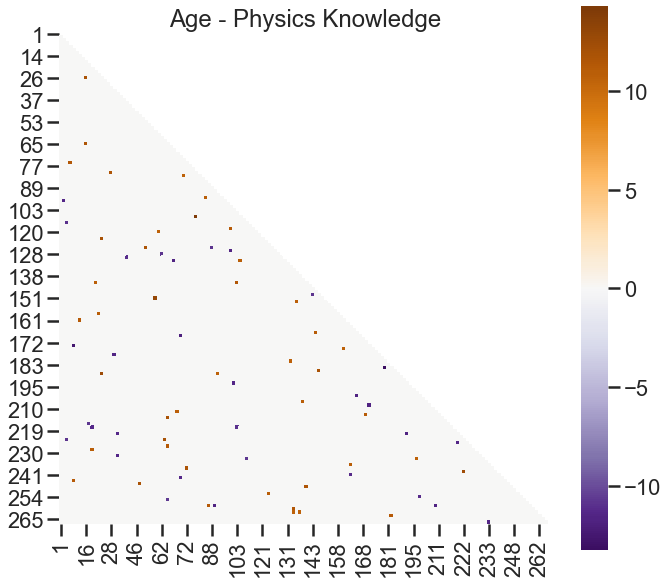

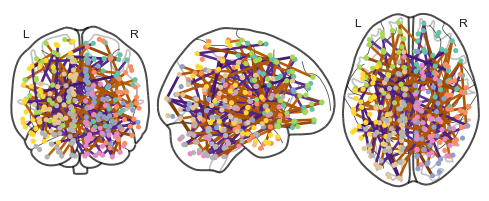

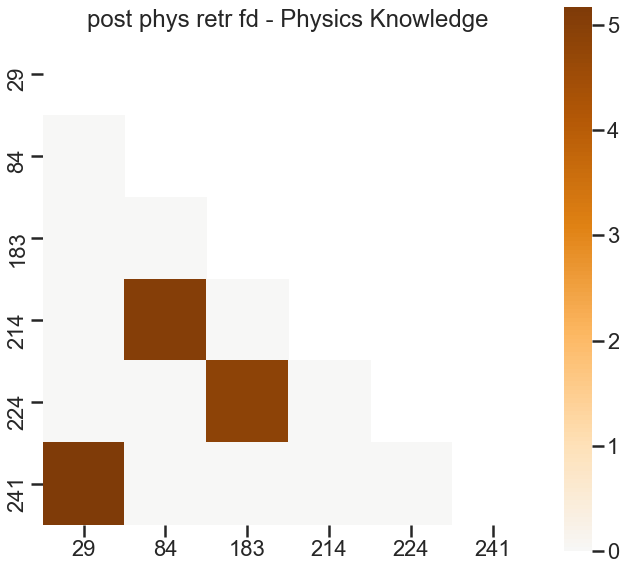

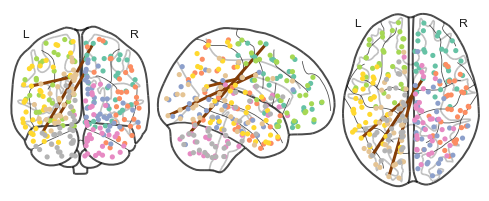

In [14]:
mask = 'shen2015'
node_size = 17
key = 'post phys retr'
for iq in effs['post phys retr']: 
    specvars = ['{0}'.format(iq), '{0}XSex'.format(iq), '{0}XClass'.format(iq), 
                '{0}XClassXSex'.format(iq),
                'F', 'Strt.Level', 'SexXClass', 'Age', 'Mod', '{0} fd'.format(key)]
    for var in specvars:
        covariates = list(set(specvars) - set([var]))
        p, t, _ = permuted_ols(all_data[var], 
                            all_data[conns], 
                            all_data[covariates],
                            n_perm=500)
        print(iq, var, 'max nlog(p)', np.max(p[0]))
        sig['post (IQ): {0}'.format(iq, var)] = np.max(p[0])
        nodaleff_sig['{0} {1} p'.format(iq, key)] = p.T
        nodaleff_sig['{0} {1} t'.format(iq, key)] = t.T
        sig_nodes = nodaleff_sig[nodaleff_sig['{0} {1} p'.format(iq, key)] >= 1.31].index
        print('# significant edges:', len(sig_nodes))
        if key in var:
            retr_params.loc[iq, key, 'fd']['max nlog(p)'] = np.max(p[0])
            retr_params.loc[iq, key, 'fd']['max t'] = np.max(t[0])
            retr_params.loc[iq, key, 'fd']['nodes'] = list(sig_nodes)
        elif iq in var:
            if 'Sex' in var:
                if 'Class' in var:
                    retr_params.loc[iq, key, 'iqXsexXclass']['max nlog(p)'] = np.max(p[0])
                    retr_params.loc[iq, key, 'iqXsexXclass']['max t'] = np.max(t[0])
                    retr_params.loc[iq, key, 'iqXsexXclass']['nodes'] = list(sig_nodes)
                else:
                    retr_params.loc[iq, key, 'iqXsex']['max nlog(p)'] = np.max(p[0])
                    retr_params.loc[iq, key, 'iqXsex']['max t'] = np.max(t[0])
                    retr_params.loc[iq, key, 'iqXsex']['nodes'] = list(sig_nodes)
            if 'Class' in var:
                if not 'Sex' in var:
                    retr_params.loc[iq, key, 'iqXclass']['max nlog(p)'] = np.max(p[0])
                    retr_params.loc[iq, key, 'iqXclass']['max t'] = np.max(t[0])
                    retr_params.loc[iq, key, 'iqXclass']['nodes'] = list(sig_nodes)
            else:
                retr_params.loc[iq, key, 'iq']['max nlog(p)'] = np.max(p[0])
                retr_params.loc[iq, key, 'iq']['max t'] = np.max(t[0])
                retr_params.loc[iq, key, 'iq']['nodes'] = list(sig_nodes)
        elif var == 'SexXClass':
            retr_params.loc[iq, key, 'sexXclass']['max nlog(p)'] = np.max(p[0])
            retr_params.loc[iq, key, 'sexXclass']['max t'] = np.max(t[0])
            retr_params.loc[iq, key, 'sexXclass']['nodes'] = list(sig_nodes)
        else:
            retr_params.loc[iq, key, var]['max nlog(p)'] = np.max(p[0])
            retr_params.loc[iq, key, var]['max t'] = np.max(t[0])
            retr_params.loc[iq, key, var]['nodes'] = list(sig_nodes)
        if np.max(p) >= 1.5:
            temp_df = pd.DataFrame(t, columns=conn_df.columns)
            tdf = pd.DataFrame(columns=np.arange(1,269), index=np.arange(1,269))
            for node1 in tdf.index:
                for node2 in tdf.columns:
                    if node1 == node2:
                        tdf.at[node1,node2] = 0
                    elif node1 > node2:
                        tdf.at[node1,node2] = temp_df.loc[0][(node1,node2)]
                    else:
                        pass
            tdf.fillna(0, inplace=True)
            tdf.to_csv(join(sink_dir, '{0}-{1}_retr_tval.csv'.format(mask,var)))
            
            temp_df = pd.DataFrame(p, columns=conn_df.columns)
            pdf = pd.DataFrame(columns=np.arange(1,269), index=np.arange(1,269))
            #this is 
            for node1 in pdf.index:
                for node2 in pdf.columns:
                    if node1 == node2:
                        pdf.at[node1,node2] = 0
                    elif node1 > node2:
                        pdf.at[node1,node2] = temp_df.loc[0][(node1,node2)]
                    else:
                        pass
            pdf.fillna(0, inplace=True)
            pdf.to_csv(join(sink_dir, '{0}-{1}_retr_pval.csv'.format(mask,var)))

            sig_edges = tdf[pdf > 1.3]
            sig_edges.fillna(0).to_csv(join(sink_dir, '{0}-{1}_retr_sig-edges.csv'.format(mask,var)))
            col = sig_edges.dropna(how='all', axis=0).index
            row = sig_edges.dropna(how='all', axis=1).columns

            ucol = set(col) - set(row)
            urow = set(row) - set(col)
            keep = list(ucol) + list(urow)
            hmap = pd.DataFrame(index=keep, columns=keep)

            for i in keep:
                for j in keep:
                    hmap.at[i,j] = sig_edges.loc[i][j]
            hmap.fillna(0, inplace=True)
            hmap.sort_index(axis=1, inplace=True)
            hmap.sort_index(axis=0, inplace=True)

            trimask = np.zeros_like(hmap.values)
            trimask[np.triu_indices_from(trimask)] = True
            sig_edges.fillna(0, inplace=True)

            fig,ax = plt.subplots(figsize=(11,10))
            sns.axes_style("white")
            k = sns.heatmap(hmap, mask=trimask, square=True, cmap='PuOr_r', center=0)
            k.set_title('{0} - Physics Knowledge'.format(var))
            fig.savefig(join(fig_dir, '{0}-{1}_retr_heatmap.png'.format(mask,var)), dpi=300)
            
            p = sig_edges + sig_edges.T
            g = plot_connectome(p, masks[mask]['coordinates'], 
                                node_size=10, edge_threshold=2., edge_cmap='PuOr_r')
            g.savefig(join(fig_dir, '{0}-{1}_retr_connectivity.png'.format(mask,var)))

In [15]:
retr_params.dropna(how='all', inplace=True)
retr_params.to_csv(join(sink_dir, 'whole_brain-permuted_ols_retr_shen2015.csv'))

In [16]:
#read in every person's connectivity matrix (yikes)
#one task & condition at a time, I think. otherwise it becomes a memory issue
np.arange(0,)
index = pd.MultiIndex.from_product([nodes, nodes])
conn_df = pd.DataFrame(columns=index)
mask = 'shen2015'
for subject in subjects:
    try:
        corrmat = np.genfromtxt(join(sink_dir, '{0}-session-1_fci-Physics_{1}-corrmat.csv'.format(subject, mask)),
                                delimiter=' ')
        np.fill_diagonal(corrmat, 0)
        zmat = np.arctanh(corrmat)
        corrs = pd.DataFrame(zmat, index=nodes, columns=nodes)
        #this is c-ordering
        for node1 in nodes:
            for node2 in nodes:
                if node1 > node2:
                    conn_df.at[subject,(node1,node2)] = corrs.loc[node1][node2]
        #conn_df.at[subject] = np.ravel(zmat, order='F')
    except Exception as e:
        print(subject, e)
#fortran ordering does first index changing fastest, last changing slowest
#c-ordering does first changing slowest, last changing fastest
conn_df.dropna(how='all', axis=1, inplace=True)
#avg_corrmat = conn_df.mean(axis=0).values.reshape((268,268), order='F')
#avg_corrmat_df = pd.DataFrame(avg_corrmat, index=np.arange(1,269), columns=np.arange(1,269))

213 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/213-session-1_fci-Physics_shen2015-corrmat.csv not found.
217 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/217-session-1_fci-Physics_shen2015-corrmat.csv not found.
322 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/322-session-1_fci-Physics_shen2015-corrmat.csv not found.
329 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/329-session-1_fci-Physics_shen2015-corrmat.csv not found.
332 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/332-session-1_fci-Physics_shen2015-corrmat.csv not found.
348 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/348-session-1_fci-Physics_shen2015-corrmat.csv not found.
452 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/452-session-1_fci-Physics_shen2015-corrmat.csv not found.
456 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/456-session-1_fci-Physics_shen2015-corrmat.csv not found.


In [17]:
big_df.index= big_df.index.astype(int)
conn_df.index = conn_df.index.astype(int)
conn_df = conn_df.astype('float')

conn_df.dropna(how='all', axis=1, inplace=True)
conns = list(set(conn_df.columns))

all_data = pd.concat([big_df, conn_df], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

In [18]:
effs = {'post phys fci':['deltaPRI', 'deltaFSIQ'],
        'post phys retr': ['WMI2', 'VCI2']}
iqs = effs['post phys fci'] + effs['post phys retr']
variables = ['iq', 'iqXsex', 'iqXclass', 'iqXsexXclass', 'sexXclass', 'F', 'Mod', 'Age', 
             'Strt.Level', 'fd']

sig = {}
nodaleff_sig = pd.DataFrame(index=conns)
index = pd.MultiIndex.from_product([iqs, effs.keys(), variables])
fci_params = pd.DataFrame(index=index, columns=['max nlog(p)', 'max t', 'edges'])

deltaPRI deltaPRI max nlog(p) 2.0977777345392834
# significant edges: 69
deltaPRI deltaPRIXSex max nlog(p) 2.0008677215312267
# significant edges: 35
deltaPRI deltaPRIXClass max nlog(p) 2.3988077302032647
# significant edges: 23
deltaPRI deltaPRIXClassXSex max nlog(p) 1.854739685852989
# significant edges: 6
deltaPRI F max nlog(p) 0.4233759216940016
# significant edges: 0
deltaPRI Strt.Level max nlog(p) 2.3988077302032647
# significant edges: 12
deltaPRI SexXClass max nlog(p) 0.334349740976346
# significant edges: 0
deltaPRI Age max nlog(p) 2.699837725867246
# significant edges: 2963
deltaPRI Mod max nlog(p) 0.4518644595054391
# significant edges: 0
deltaPRI post phys fci fd max nlog(p) 1.6206564798196208
# significant edges: 2
deltaFSIQ deltaFSIQ max nlog(p) 0.9074460363689919
# significant edges: 0
deltaFSIQ deltaFSIQXSex max nlog(p) 1.1087731188407466
# significant edges: 0
deltaFSIQ deltaFSIQXClass max nlog(p) 1.009641645838732
# significant edges: 0
deltaFSIQ deltaFSIQXClassXSex m

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/nilearn/plotting/displays.py:602: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


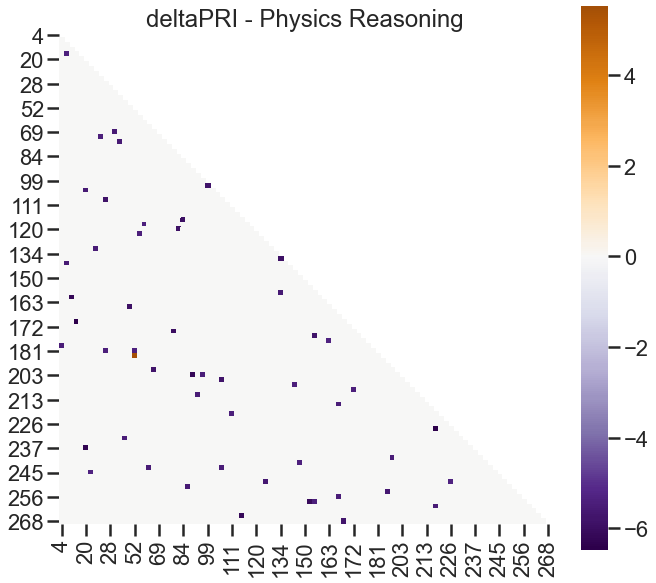

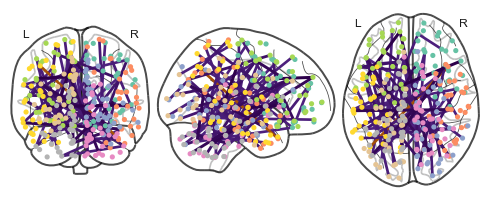

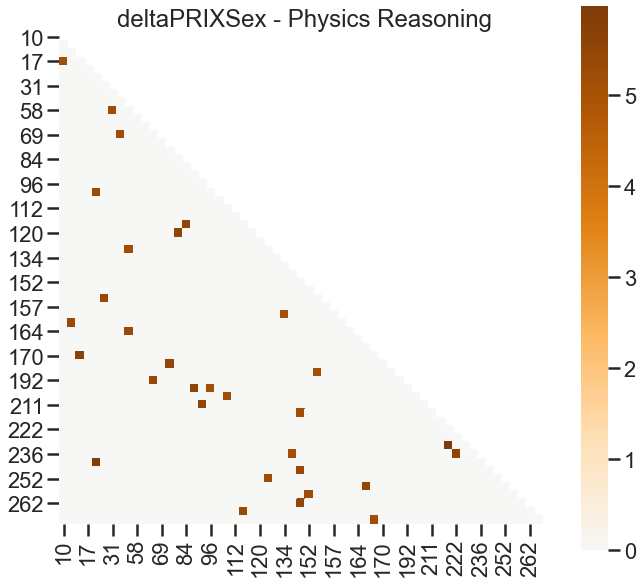

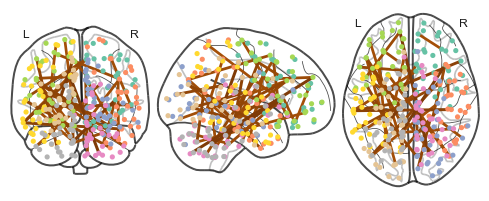

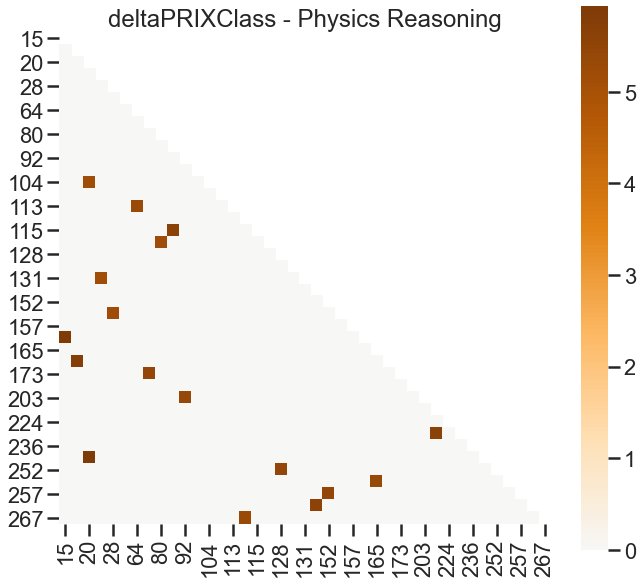

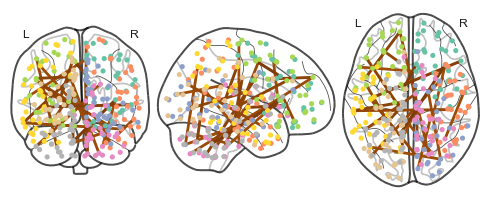

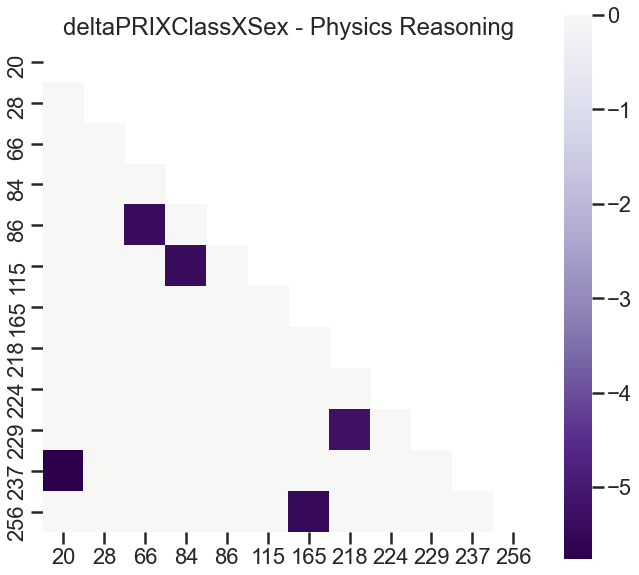

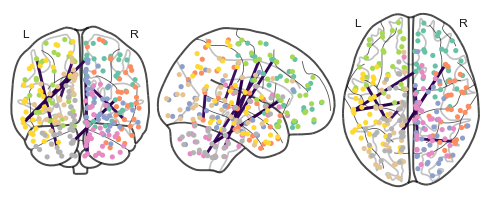

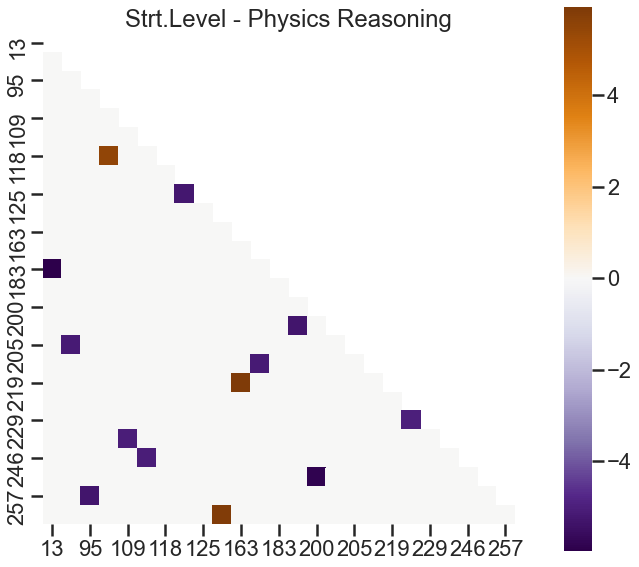

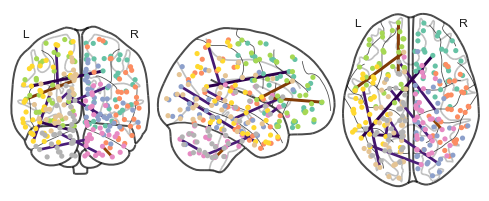

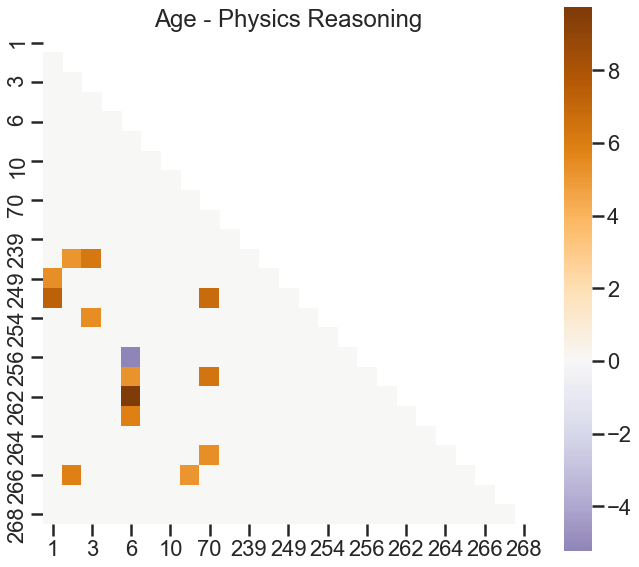

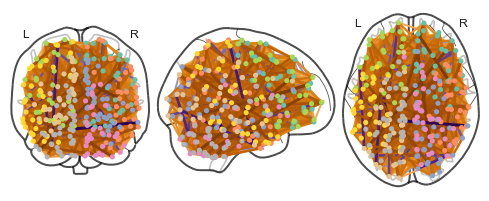

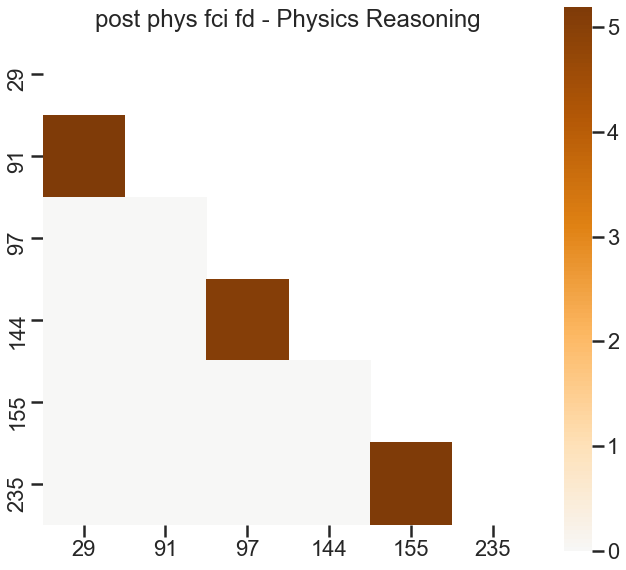

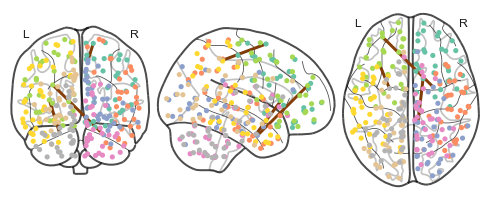

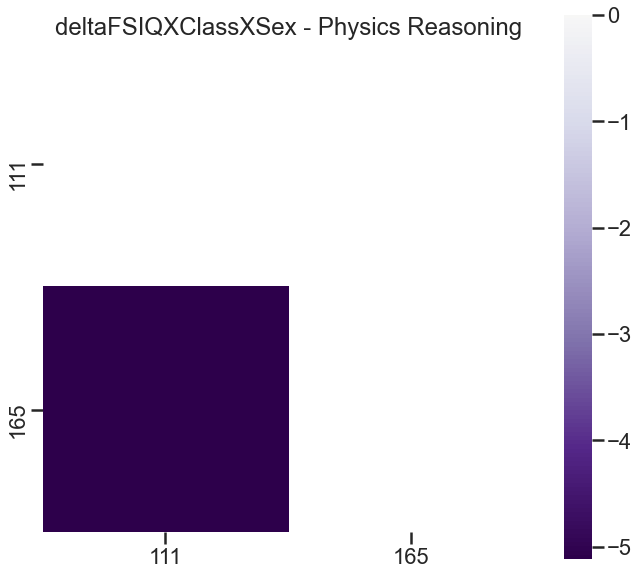

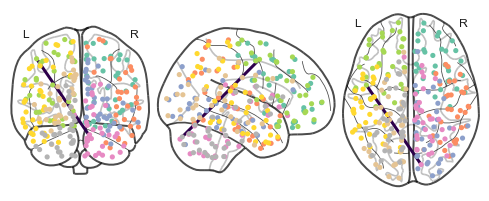

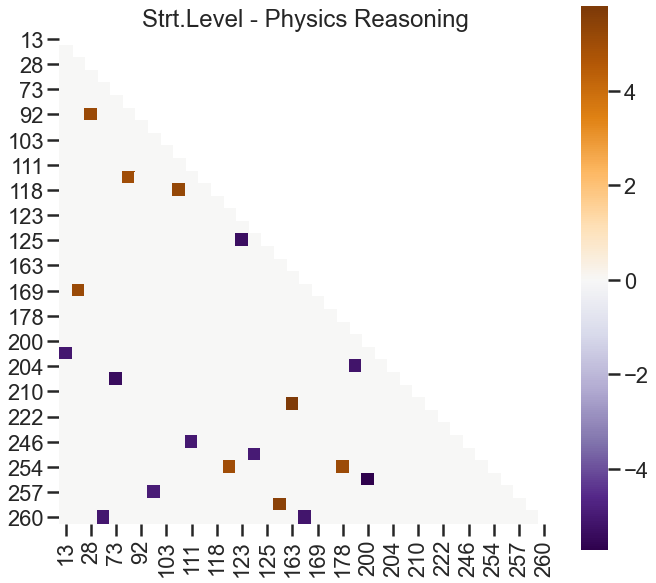

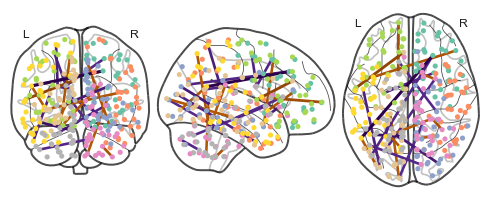

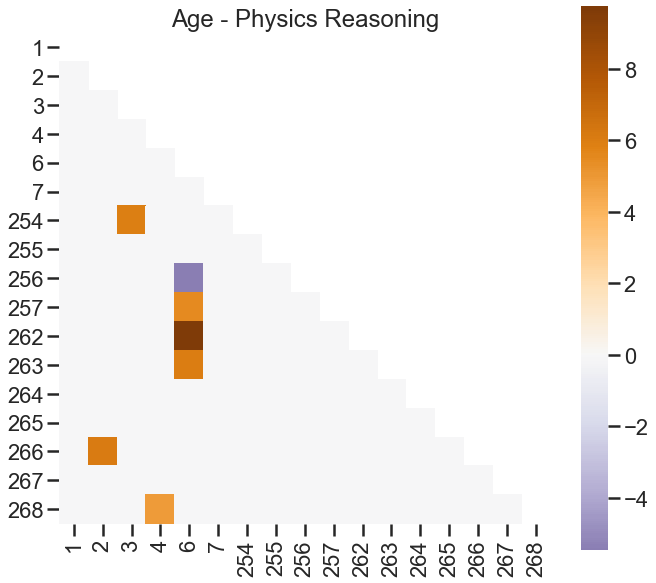

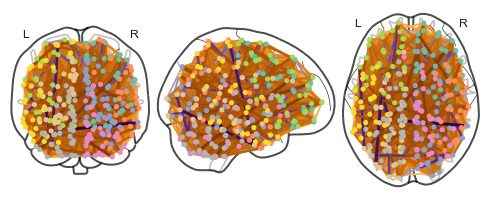

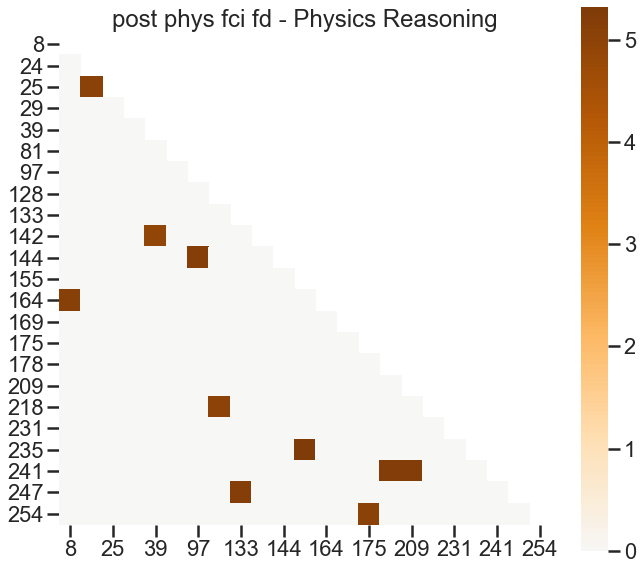

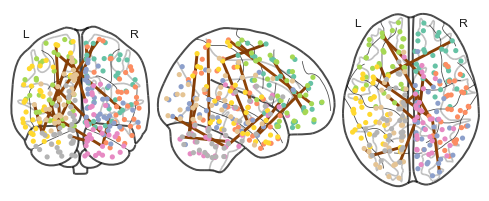

In [19]:
mask = 'shen2015'
node_size = 17
key = 'post phys fci'
for iq in effs[key]: 
    specvars = ['{0}'.format(iq), '{0}XSex'.format(iq), '{0}XClass'.format(iq), 
                '{0}XClassXSex'.format(iq),
                'F', 'Strt.Level', 'SexXClass', 'Age', 'Mod', '{0} fd'.format(key)]
    for var in specvars:
        covariates = list(set(specvars) - set([var]))
        p, t, _ = permuted_ols(all_data[var], 
                            all_data[conns], 
                            all_data[covariates],
                            n_perm=500)
        print(iq, var, 'max nlog(p)', np.max(p[0]))
        sig['post (IQ): {0}'.format(iq, var)] = np.max(p[0])
        nodaleff_sig['{0} {1} p'.format(iq, key)] = p.T
        nodaleff_sig['{0} {1} t'.format(iq, key)] = t.T
        sig_nodes = nodaleff_sig[nodaleff_sig['{0} {1} p'.format(iq, key)] >= 1.31].index
        print('# significant edges:', len(sig_nodes))
        if key in var:
            fci_params.loc[iq, key, 'fd']['max nlog(p)'] = np.max(p[0])
            fci_params.loc[iq, key, 'fd']['max t'] = np.max(t[0])
            fci_params.loc[iq, key, 'fd']['nodes'] = list(sig_nodes)
        elif iq in var:
            if 'Sex' in var:
                if 'Class' in var:
                    fci_params.loc[iq, key, 'iqXsexXclass']['max nlog(p)'] = np.max(p[0])
                    fci_params.loc[iq, key, 'iqXsexXclass']['max t'] = np.max(t[0])
                    fci_params.loc[iq, key, 'iqXsexXclass']['nodes'] = list(sig_nodes)
                else:
                    fci_params.loc[iq, key, 'iqXsex']['max nlog(p)'] = np.max(p[0])
                    fci_params.loc[iq, key, 'iqXsex']['max t'] = np.max(t[0])
                    fci_params.loc[iq, key, 'iqXsex']['nodes'] = list(sig_nodes)
            if 'Class' in var:
                if not 'Sex' in var:
                    fci_params.loc[iq, key, 'iqXclass']['max nlog(p)'] = np.max(p[0])
                    fci_params.loc[iq, key, 'iqXclass']['max t'] = np.max(t[0])
                    fci_params.loc[iq, key, 'iqXclass']['nodes'] = list(sig_nodes)
            else:
                fci_params.loc[iq, key, 'iq']['max nlog(p)'] = np.max(p[0])
                fci_params.loc[iq, key, 'iq']['max t'] = np.max(t[0])
                fci_params.loc[iq, key, 'iq']['nodes'] = list(sig_nodes)
        elif var == 'SexXClass':
            fci_params.loc[iq, key, 'sexXclass']['max nlog(p)'] = np.max(p[0])
            fci_params.loc[iq, key, 'sexXclass']['max t'] = np.max(t[0])
            fci_params.loc[iq, key, 'sexXclass']['nodes'] = list(sig_nodes)
        else:
            fci_params.loc[iq, key, var]['max nlog(p)'] = np.max(p[0])
            fci_params.loc[iq, key, var]['max t'] = np.max(t[0])
            fci_params.loc[iq, key, var]['nodes'] = list(sig_nodes)
        if np.max(p) >= 1.5:
            temp_df = pd.DataFrame(t, columns=conn_df.columns)
            tdf = pd.DataFrame(columns=np.arange(1,269), index=np.arange(1,269))
            for node1 in tdf.index:
                for node2 in tdf.columns:
                    if node1 == node2:
                        tdf.at[node1,node2] = 0
                    elif node1 > node2:
                        tdf.at[node1,node2] = temp_df.loc[0][(node1,node2)]
                    else:
                        pass
            tdf.fillna(0, inplace=True)
            tdf.to_csv(join(sink_dir, '{0}-{1}_fci_tval.csv'.format(mask,var)))
            
            temp_df = pd.DataFrame(p, columns=conn_df.columns)
            pdf = pd.DataFrame(columns=np.arange(1,269), index=np.arange(1,269))
            #this is 
            for node1 in pdf.index:
                for node2 in pdf.columns:
                    if node1 == node2:
                        pdf.at[node1,node2] = 0
                    elif node1 > node2:
                        pdf.at[node1,node2] = temp_df.loc[0][(node1,node2)]
                    else:
                        pass
            pdf.fillna(0, inplace=True)
            pdf.to_csv(join(sink_dir, '{0}-{1}_fci_pval.csv'.format(mask,var)))

            sig_edges = tdf[pdf > 1.3]
            sig_edges.fillna(0).to_csv(join(sink_dir, '{0}-{1}_fci_sig-edges.csv'.format(mask,var)))
            col = sig_edges.dropna(how='all', axis=0).index
            row = sig_edges.dropna(how='all', axis=1).columns

            ucol = set(col) - set(row)
            urow = set(row) - set(col)
            keep = list(ucol) + list(urow)
            hmap = pd.DataFrame(index=keep, columns=keep)

            for i in keep:
                for j in keep:
                    hmap.at[i,j] = sig_edges.loc[i][j]
            hmap.fillna(0, inplace=True)
            hmap.sort_index(axis=1, inplace=True)
            hmap.sort_index(axis=0, inplace=True)

            trimask = np.zeros_like(hmap.values)
            trimask[np.triu_indices_from(trimask)] = True
            sig_edges.fillna(0, inplace=True)

            fig,ax = plt.subplots(figsize=(11,10))
            sns.axes_style("white")
            k = sns.heatmap(hmap, mask=trimask, square=True, cmap='PuOr_r', center=0)
            k.set_title('{0} - Physics Reasoning'.format(var))
            fig.savefig(join(fig_dir, '{0}-{1}_fci_heatmap.png'.format(mask,var)), dpi=300)
            
            p = sig_edges + sig_edges.T
            g = plot_connectome(p, masks[mask]['coordinates'], 
                                node_size=10, edge_threshold=2., edge_cmap='PuOr_r')
            g.savefig(join(fig_dir, '{0}-{1}_fci_connectivity.png'.format(mask,var)))

In [20]:
fci_params.dropna(how='all', inplace=True)
fci_params.to_csv(join(sink_dir, 'whole_brain-permuted_ols_fci_shen2015.csv'))

### Repeat with Craddock parcellation

213 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/213-session-1_retr-Physics_shen2015-corrmat.csv not found.
217 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/217-session-1_retr-Physics_shen2015-corrmat.csv not found.
322 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/322-session-1_retr-Physics_shen2015-corrmat.csv not found.
329 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/329-session-1_retr-Physics_shen2015-corrmat.csv not found.
332 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/332-session-1_retr-Physics_shen2015-corrmat.csv not found.
452 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/452-session-1_retr-Physics_shen2015-corrmat.csv not found.
456 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/456-session-1_retr-Physics_shen2015-corrmat.csv not found.
457 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/457-session-1_retr-Physics_shen2015-corrmat.csv not

463 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/463-session-1_fci-Physics_shen2015-corrmat.csv not found.
502 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/502-session-1_fci-Physics_shen2015-corrmat.csv not found.
575 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/575-session-1_fci-Physics_shen2015-corrmat.csv not found.
579 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/579-session-1_fci-Physics_shen2015-corrmat.csv not found.
580 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/580-session-1_fci-Physics_shen2015-corrmat.csv not found.
582 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/582-session-1_fci-Physics_shen2015-corrmat.csv not found.
590 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/590-session-1_fci-Physics_shen2015-corrmat.csv not found.
611 /Users/kbottenh/Dropbox/Projects/physics-retrieval/data/output/611-session-1_fci-Physics_shen2015-corrmat.csv not found.


/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/nilearn/plotting/displays.py:602: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


deltaPRI deltaPRIXClass max nlog(p) 1.921686475483602
# significant edges: 19
deltaPRI deltaPRIXClassXSex max nlog(p) 1.7967477388753021
# significant edges: 7
deltaPRI F max nlog(p) 0.4719510212535722
# significant edges: 0
deltaPRI Strt.Level max nlog(p) 2.3988077302032647
# significant edges: 13
deltaPRI SexXClass max nlog(p) 0.3036383787715094
# significant edges: 0
deltaPRI Age max nlog(p) 2.2227164711475833
# significant edges: 2791
deltaPRI Mod max nlog(p) 0.39020755844134697
# significant edges: 0
deltaPRI post phys fci fd max nlog(p) 1.495717743211321
# significant edges: 2
deltaFSIQ deltaFSIQ max nlog(p) 0.900497176413664
# significant edges: 0
deltaFSIQ deltaFSIQXSex max nlog(p) 1.1087731188407466
# significant edges: 0
deltaFSIQ deltaFSIQXClass max nlog(p) 0.8936577518833586
# significant edges: 0
deltaFSIQ deltaFSIQXClassXSex max nlog(p) 1.6998377258672457
# significant edges: 1
deltaFSIQ F max nlog(p) 0.2573579568027972
# significant edges: 0
deltaFSIQ Strt.Level max nlog

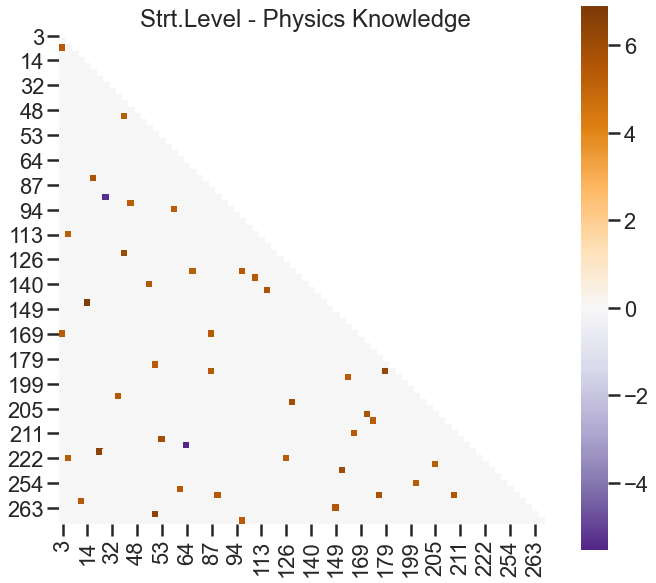

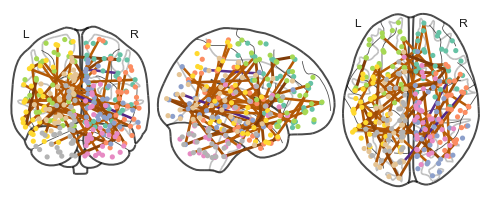

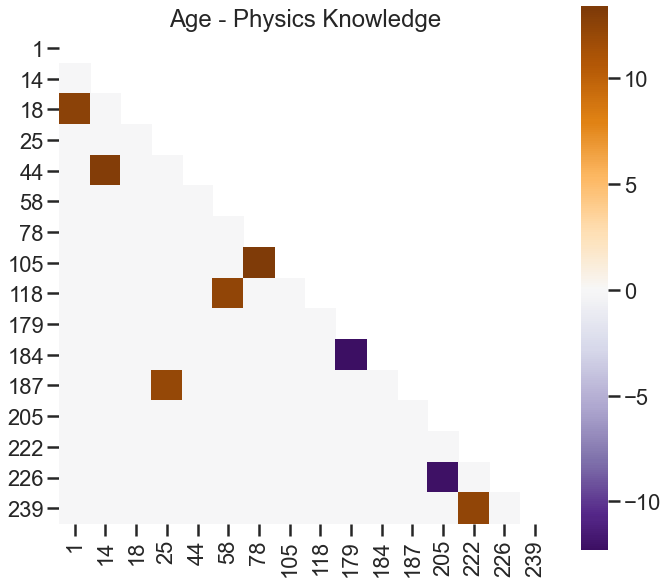

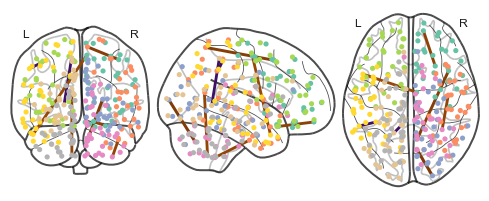

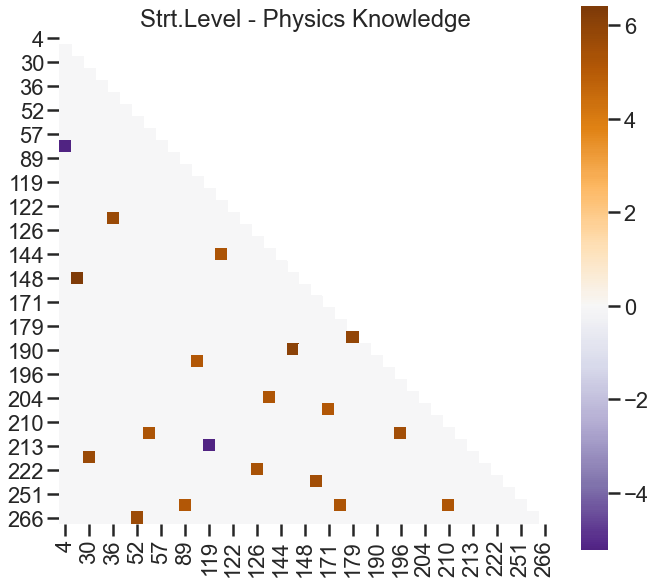

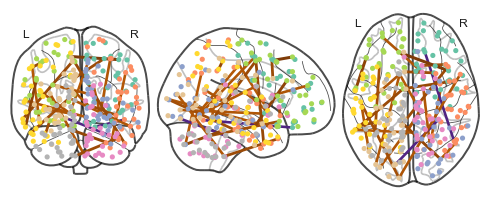

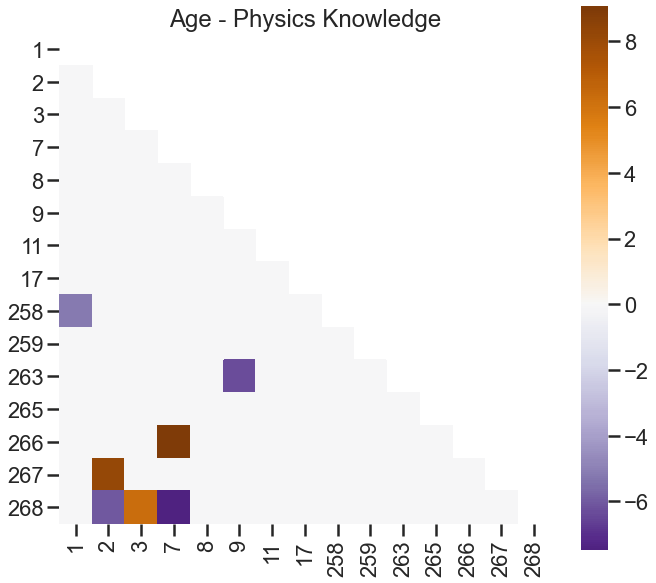

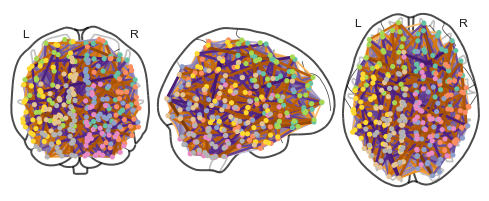

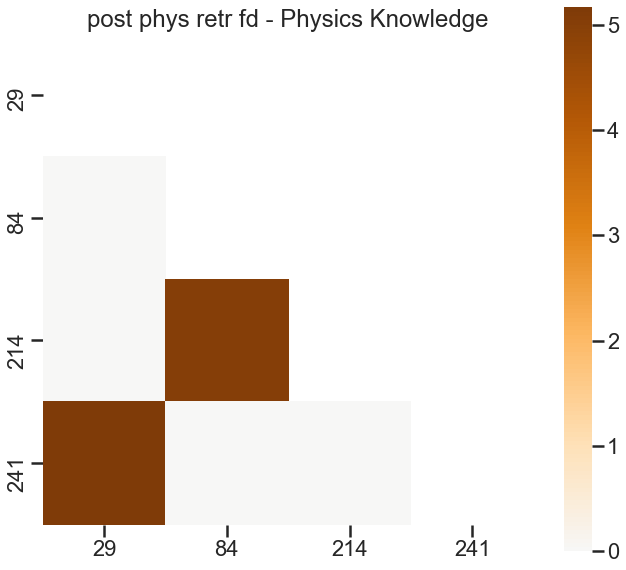

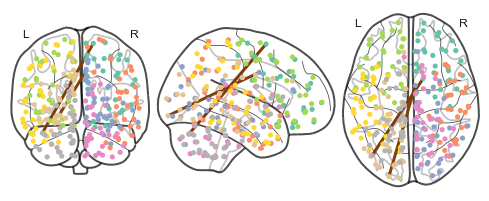

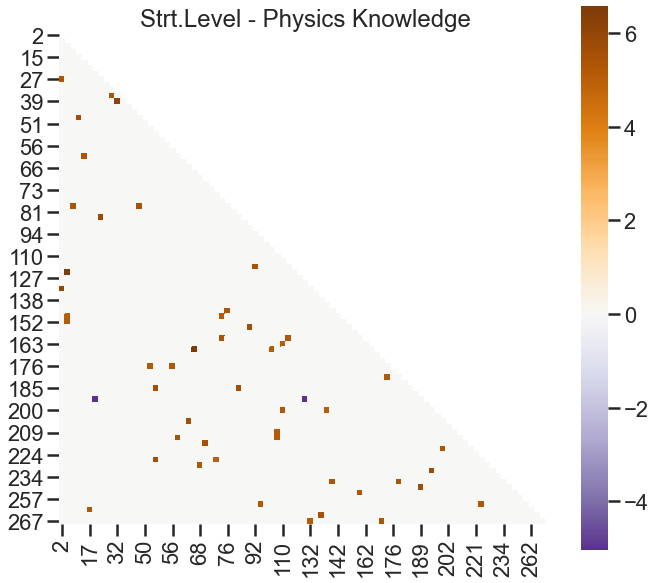

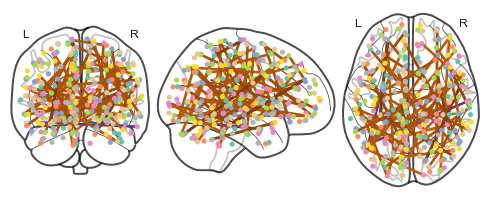

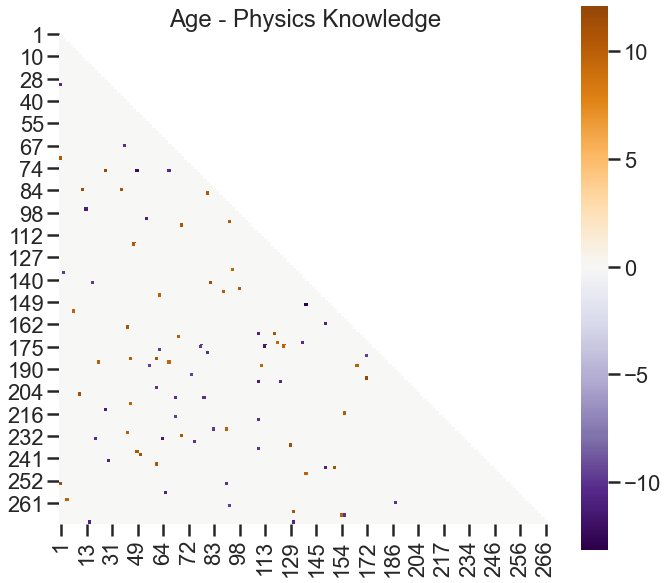

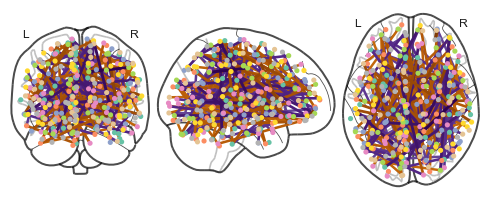

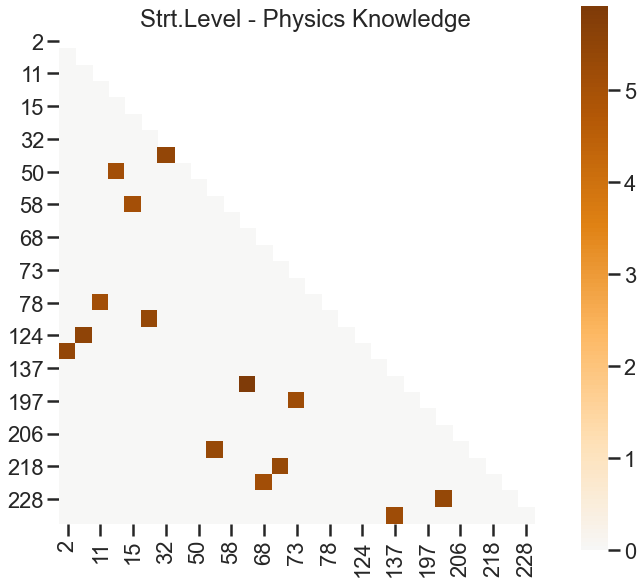

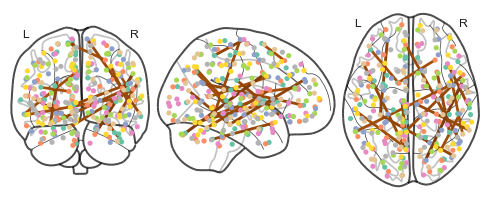

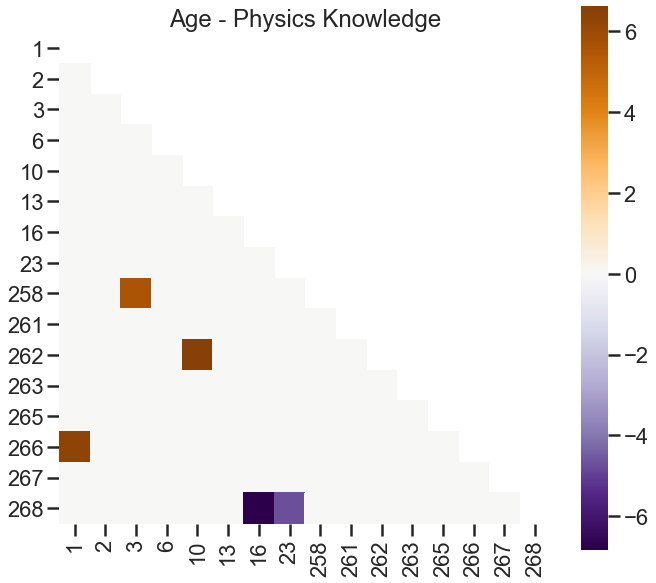

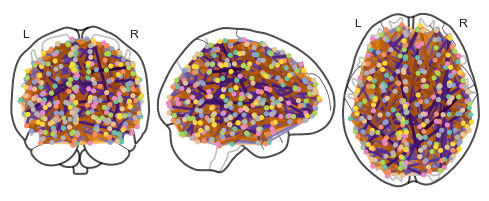

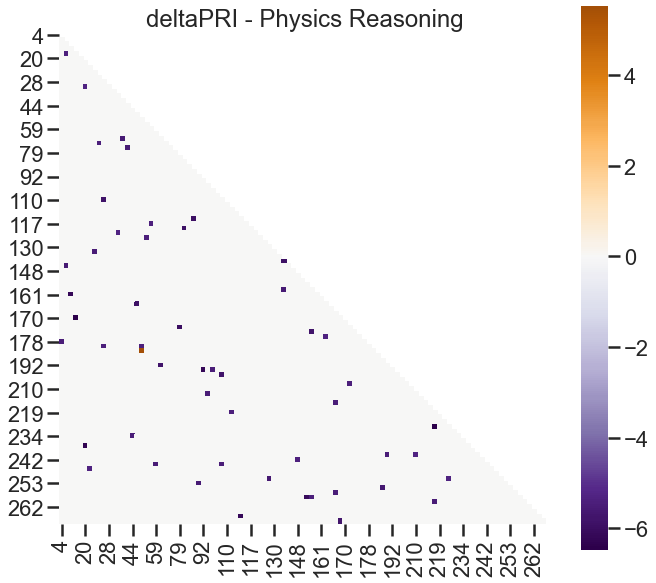

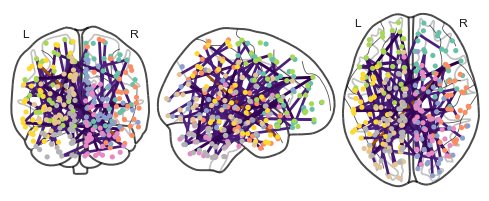

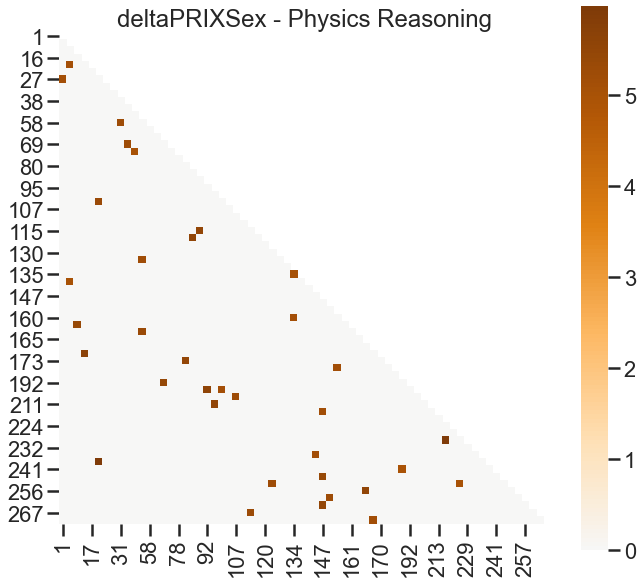

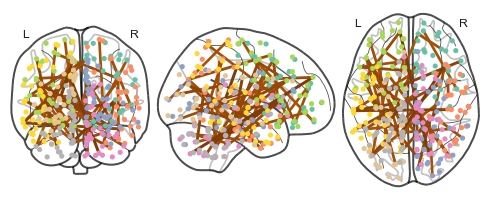

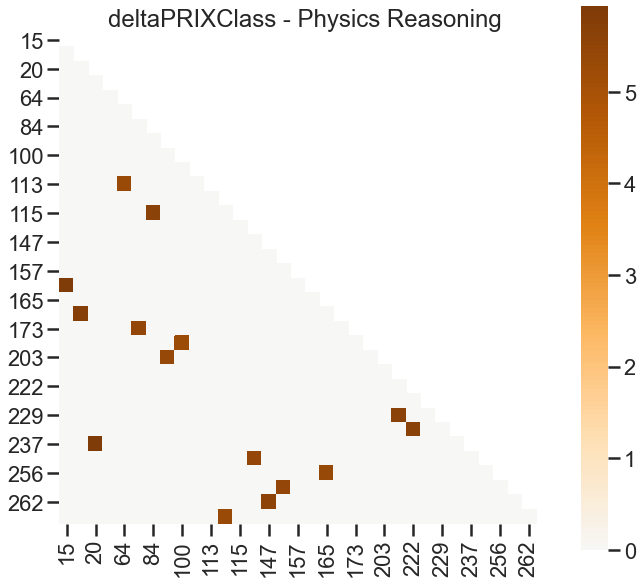

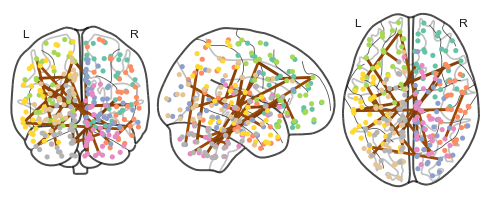

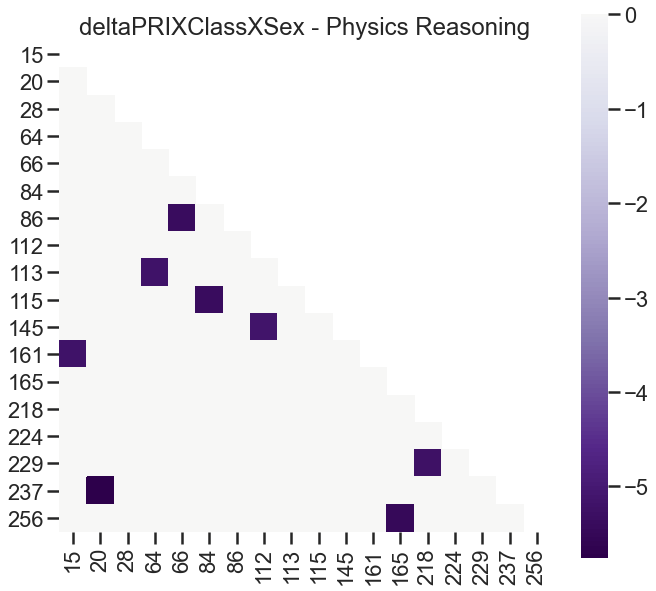

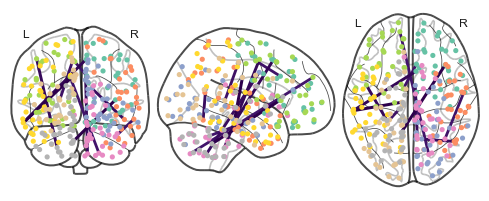

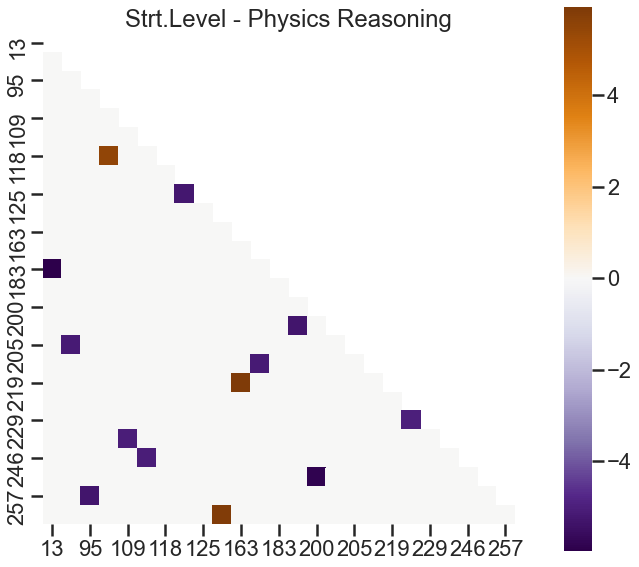

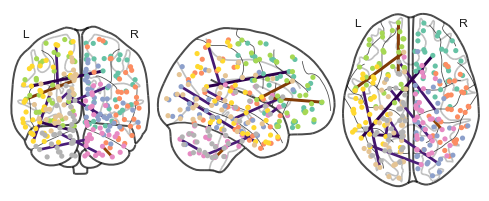

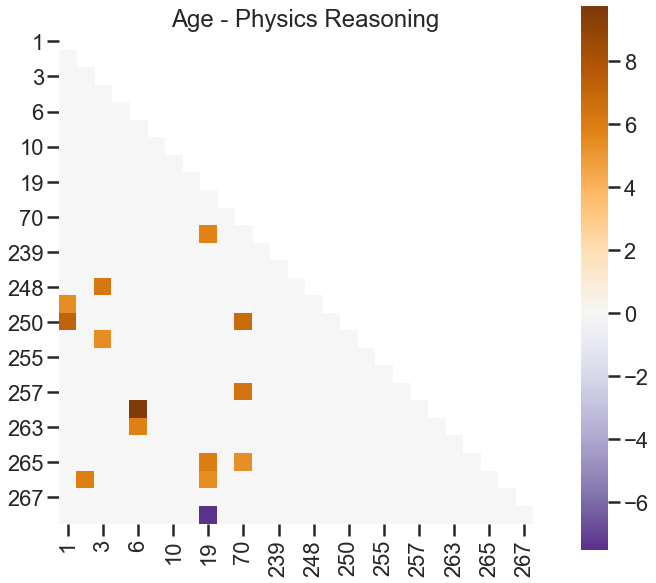

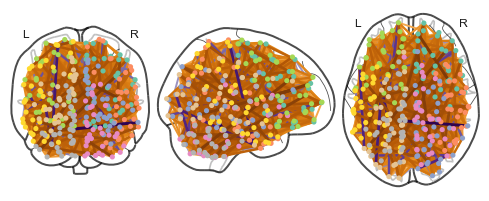

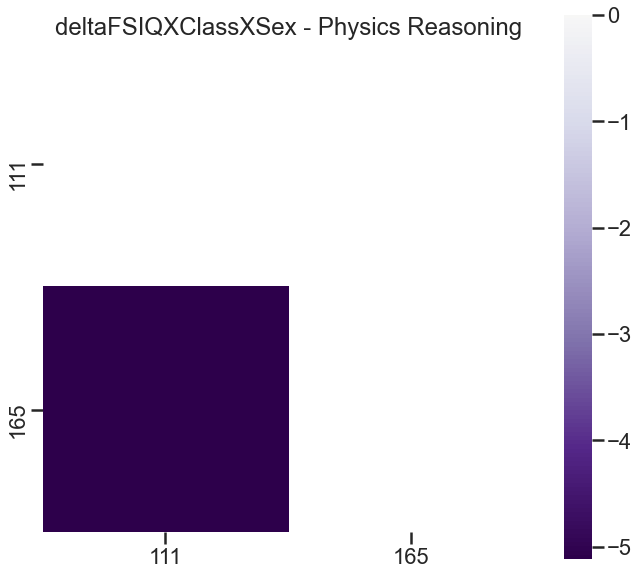

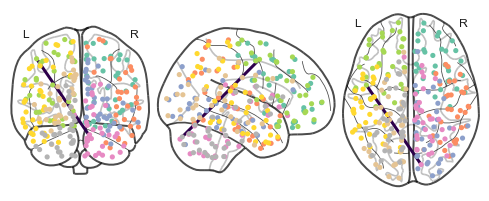

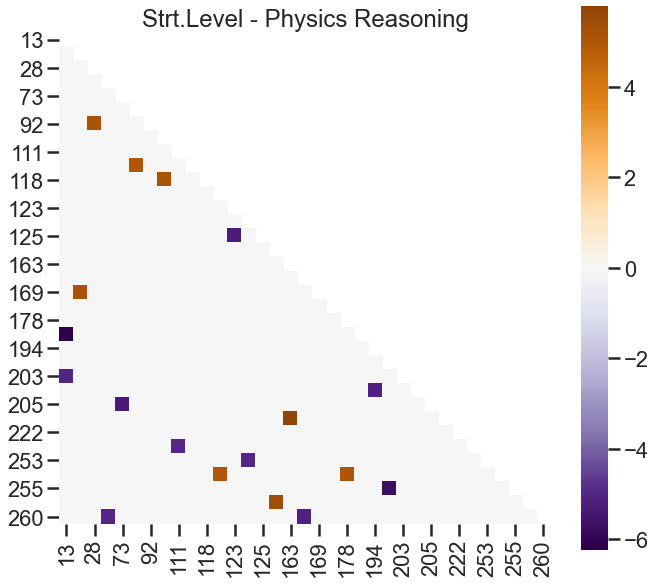

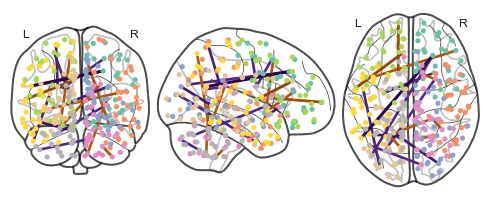

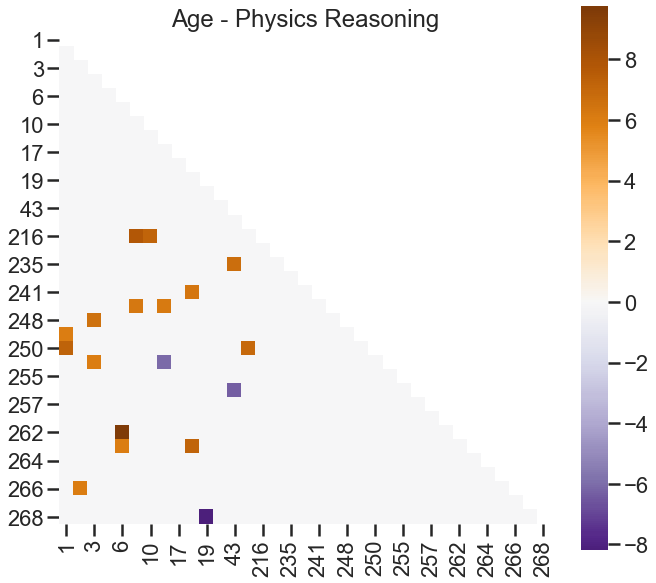

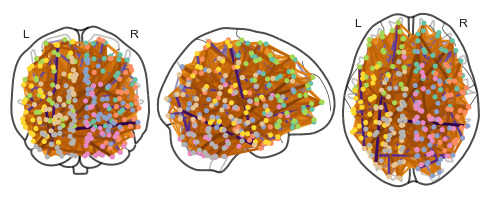

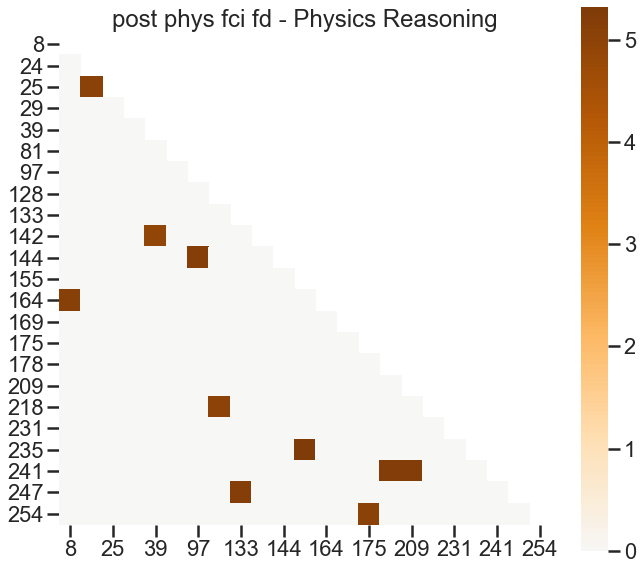

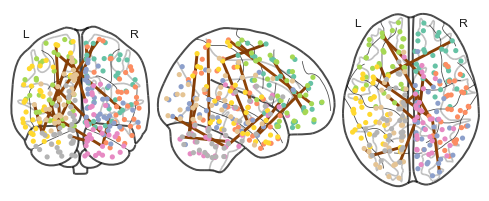

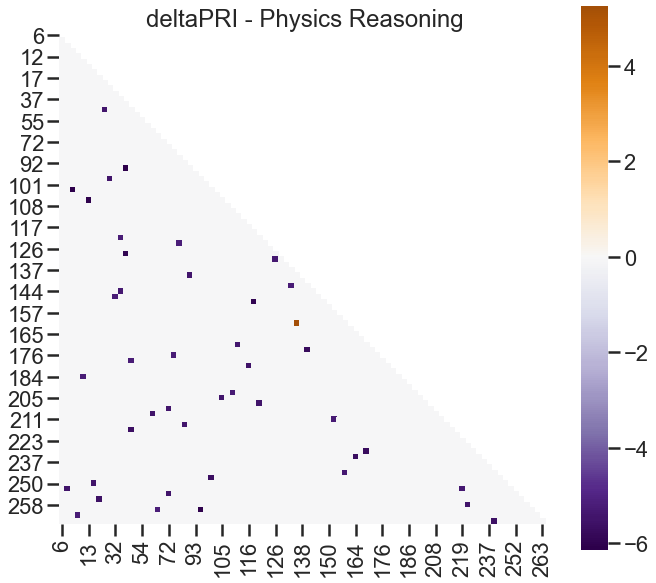

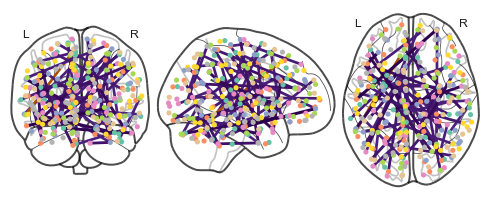

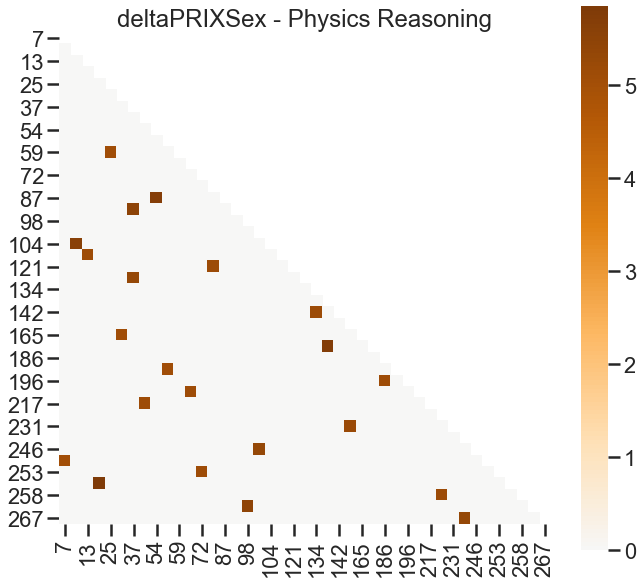

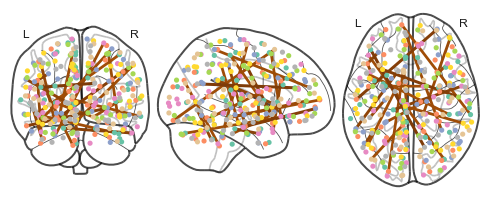

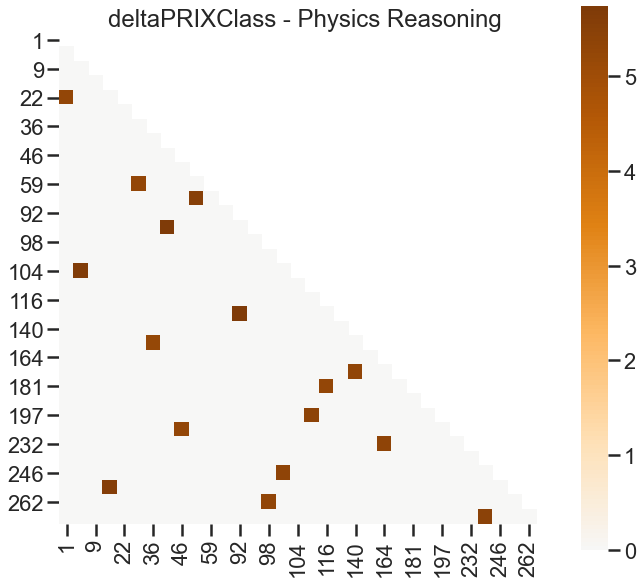

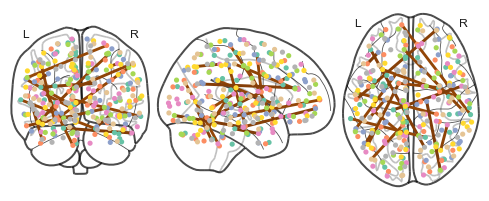

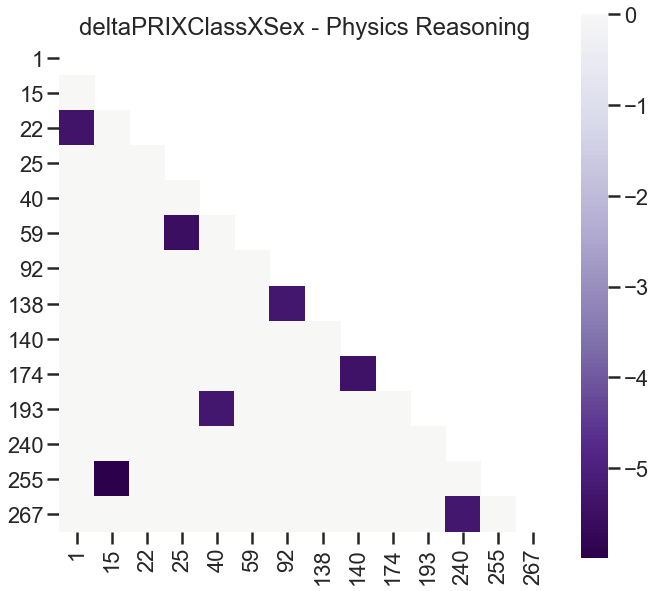

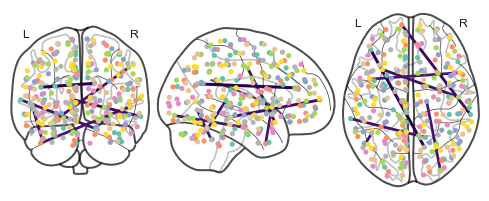

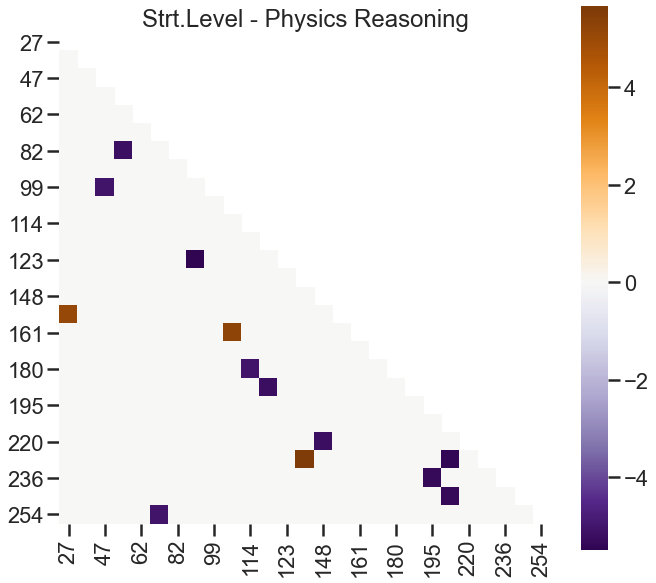

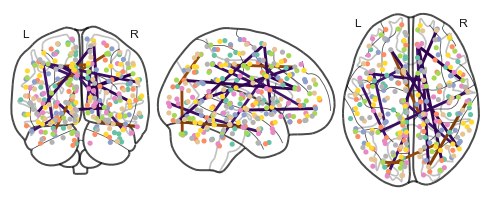

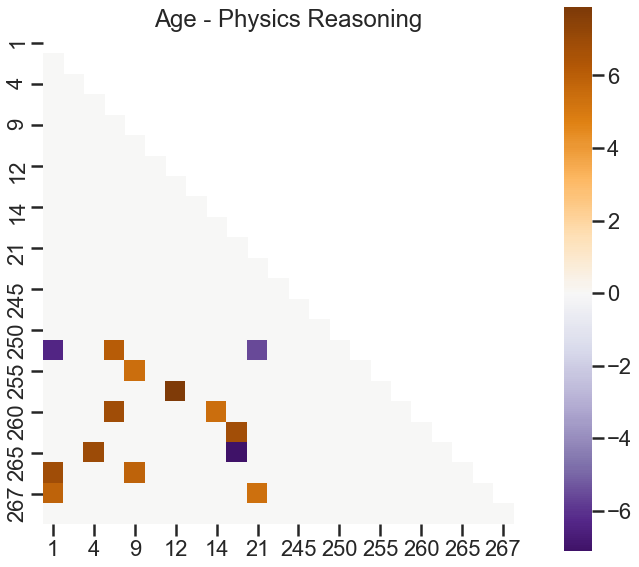

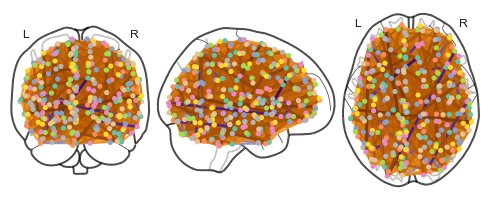

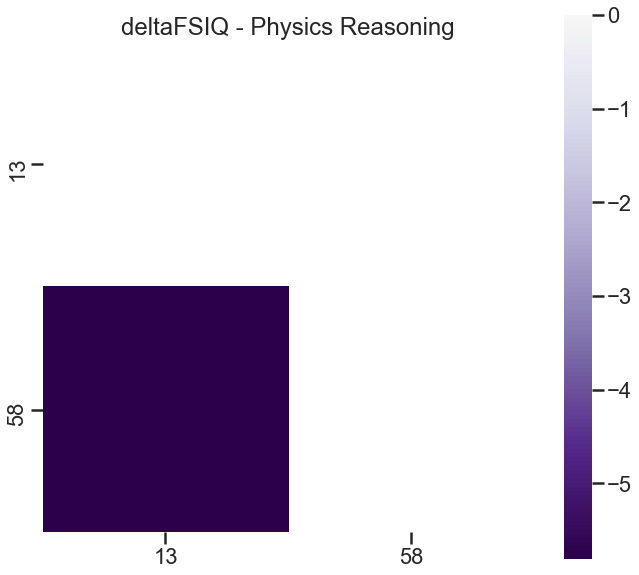

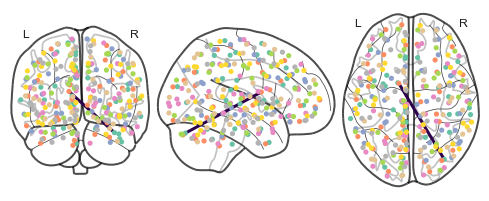

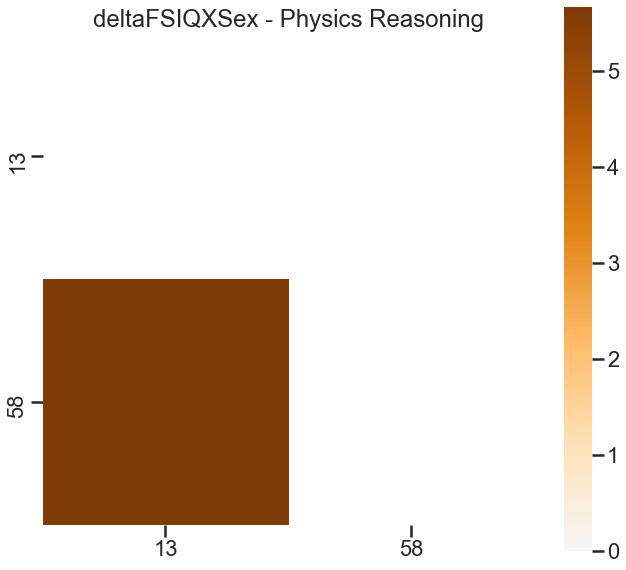

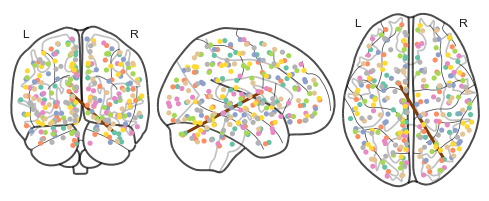

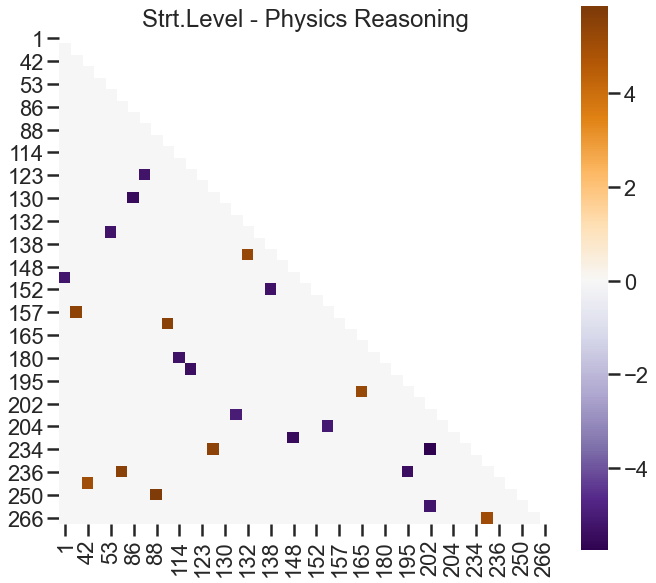

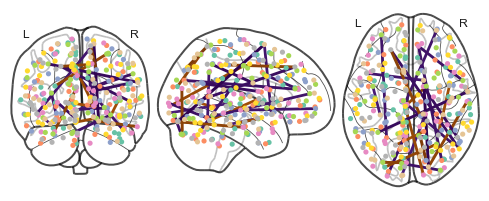

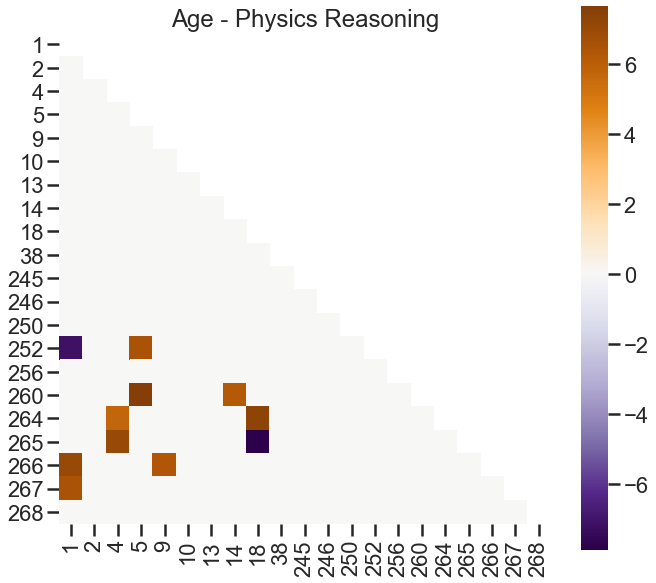

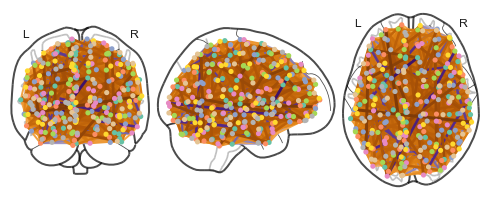

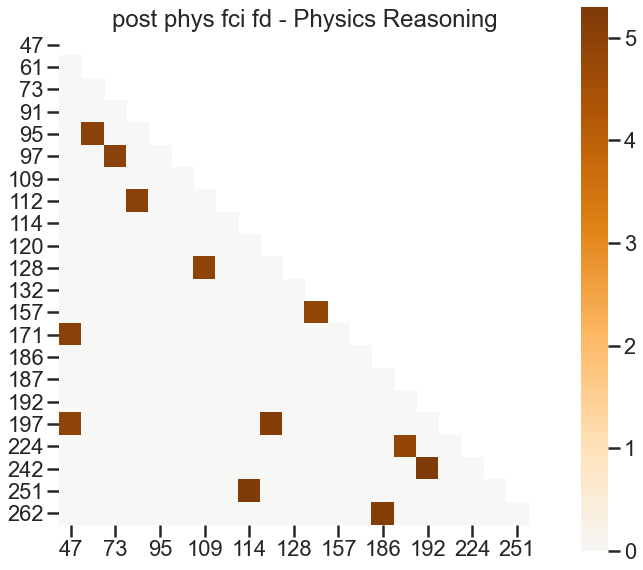

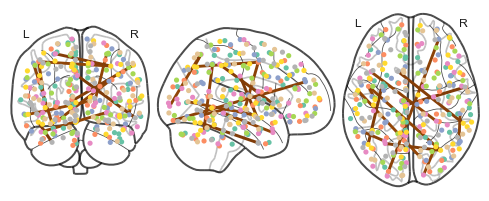

In [34]:
effs = {'retr': {'iqs':['WMI2', 'VCI2'],
                 'fd': 'post phys retr',
                 'title': 'Physics Knowledge'},
       'fci': {'iqs': ['deltaPRI', 'deltaFSIQ'],
                'fd': 'post phys fci',
                'title': 'Physics Reasoning'}}
variables = ['iq', 'iqXsex', 'iqXclass', 'iqXsexXclass', 'sexXclass', 'F', 'Mod', 'Age', 'Strt.Level', 'fd']





nodes = list(np.arange(1,269,dtype=int))
index = []
for node1 in nodes:
    for node2 in nodes:
        if node1 > node2:
            index.append((node1, node2))



#read in every person's connectivity matrix (yikes)
#one task & condition at a time, I think. otherwise it becomes a memory issue
for task in effs.keys():
    for mask in masks.keys():
        index = pd.MultiIndex.from_product([effs[task]['iqs'], effs.keys(), variables])
        params = pd.DataFrame(index=index, columns=['max nlog(p)', 'max t', 'edges'])
        
        index = pd.MultiIndex.from_product([nodes, nodes])
        conn_df = pd.DataFrame(columns=index)
        for subject in subjects:
            try:
                corrmat = np.genfromtxt(join(sink_dir, 
                                             '{0}-session-1_{1}-Physics_{2}-corrmat.csv'.format(subject, 
                                                                                                task, 
                                                                                                mask)),
                                        delimiter=' ')
                np.fill_diagonal(corrmat, 0)
                zmat = np.arctanh(corrmat)
                corrs = pd.DataFrame(zmat, index=nodes, columns=nodes)
                #this is c-ordering
                for node1 in nodes:
                    for node2 in nodes:
                        if node1 > node2:
                            conn_df.at[subject,(node1,node2)] = corrs.loc[node1][node2]
                #conn_df.at[subject] = np.ravel(zmat, order='F')
            except Exception as e:
                print(subject, e)
        #fortran ordering does first index changing fastest, last changing slowest
        #c-ordering does first changing slowest, last changing fastest
        conn_df.dropna(how='all', axis=1, inplace=True)


        # In[65]:


        big_df.index= big_df.index.astype(int)
        conn_df.index = conn_df.index.astype(int)
        conn_df = conn_df.astype('float')

        conn_df.dropna(how='all', axis=1, inplace=True)
        conns = list(set(conn_df.columns))

        sig = {}
        nodaleff_sig = pd.DataFrame(index=conns)

        all_data = pd.concat([big_df, conn_df], axis=1)
        all_data.dropna(how='any', axis=0, inplace=True)

        for iq in effs[task]['iqs']: 
            fd = effs[task]['fd']
            specvars = ['{0}'.format(iq), '{0}XSex'.format(iq), '{0}XClass'.format(iq), 
                        '{0}XClassXSex'.format(iq),
                        'F', 'Strt.Level', 'SexXClass', 'Age', 'Mod', '{0} fd'.format(fd)]
            for var in specvars:
                covariates = list(set(specvars) - set([var]))
                p, t, _ = permuted_ols(all_data[var], 
                                    all_data[conns], 
                                    all_data[covariates],
                                    n_perm=500)
                print(iq, var, 'max nlog(p)', np.max(p[0]))
                sig['post (IQ): {0}'.format(iq, var)] = np.max(p[0])
                nodaleff_sig['{0} {1} p'.format(iq, task)] = p.T
                nodaleff_sig['{0} {1} t'.format(iq, task)] = t.T
                edges = nodaleff_sig[nodaleff_sig['{0} {1} p'.format(iq, task)] >= 1.31].index
                print('# significant edges:', len(edges))
                if fd in var:
                    params.loc[iq, task, 'fd']['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, task, 'fd']['max t'] = np.max(t[0])
                    params.loc[iq, task, 'fd']['edges'] = list(edges)
                elif iq in var:
                    if 'Sex' in var:
                        if 'Class' in var:
                            params.loc[iq, task, 'iqXsexXclass']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, task, 'iqXsexXclass']['max t'] = np.max(t[0])
                            params.loc[iq, task, 'iqXsexXclass']['edges'] = list(edges)
                        else:
                            params.loc[iq, task, 'iqXsex']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, task, 'iqXsex']['max t'] = np.max(t[0])
                            params.loc[iq, task, 'iqXsex']['edges'] = list(edges)
                    if 'Class' in var:
                        if not 'Sex' in var:
                            params.loc[iq, task, 'iqXclass']['max nlog(p)'] = np.max(p[0])
                            params.loc[iq, task, 'iqXclass']['max t'] = np.max(t[0])
                            params.loc[iq, task, 'iqXclass']['edges'] = list(edges)
                    else:
                        params.loc[iq, task, 'iq']['max nlog(p)'] = np.max(p[0])
                        params.loc[iq, task, 'iq']['max t'] = np.max(t[0])
                        params.loc[iq, task, 'iq']['edges'] = list(edges)
                elif var == 'SexXClass':
                    params.loc[iq, task, 'sexXclass']['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, task, 'sexXclass']['max t'] = np.max(t[0])
                    params.loc[iq, task, 'sexXclass']['edges'] = list(edges)
                else:
                    params.loc[iq, task, var]['max nlog(p)'] = np.max(p[0])
                    params.loc[iq, task, var]['max t'] = np.max(t[0])
                    params.loc[iq, task, var]['edges'] = list(edges)
                if np.max(p) >= 1.5:
                    temp_df = pd.DataFrame(t, columns=conn_df.columns)
                    tdf = pd.DataFrame(columns=np.arange(1,269), index=np.arange(1,269))
                    for node1 in tdf.index:
                        for node2 in tdf.columns:
                            if node1 == node2:
                                tdf.at[node1,node2] = 0
                            elif node1 > node2:
                                tdf.at[node1,node2] = temp_df.loc[0][(node1,node2)]
                            else:
                                pass
                    tdf.fillna(0, inplace=True)
                    tdf.to_csv(join(sink_dir, '{0}-{1}_{2}_tval.csv'.format(mask, var, task)))

                    temp_df = pd.DataFrame(p, columns=conn_df.columns)
                    pdf = pd.DataFrame(columns=np.arange(1,269), index=np.arange(1,269))
                    #this is 
                    for node1 in pdf.index:
                        for node2 in pdf.columns:
                            if node1 == node2:
                                pdf.at[node1,node2] = 0
                            elif node1 > node2:
                                pdf.at[node1,node2] = temp_df.loc[0][(node1,node2)]
                            else:
                                pass
                    pdf.fillna(0, inplace=True)
                    pdf.to_csv(join(sink_dir, '{0}-{1}_{2}_pval.csv'.format(mask,var,task)))

                    sig_edges = tdf[pdf > 1.3]
                    sig_edges.fillna(0).to_csv(join(sink_dir, '{0}-{1}_{2}_sig-edges.csv'.format(mask,var,task)))
                    col = sig_edges.dropna(how='all', axis=0).index
                    row = sig_edges.dropna(how='all', axis=1).columns

                    ucol = set(col) - set(row)
                    urow = set(row) - set(col)
                    keep = list(ucol) + list(urow)
                    hmap = pd.DataFrame(index=keep, columns=keep)

                    for i in keep:
                        for j in keep:
                            hmap.at[i,j] = sig_edges.loc[i][j]
                    hmap.fillna(0, inplace=True)
                    hmap.sort_index(axis=1, inplace=True)
                    hmap.sort_index(axis=0, inplace=True)

                    trimask = np.zeros_like(hmap.values)
                    trimask[np.triu_indices_from(trimask)] = True
                    sig_edges.fillna(0, inplace=True)

                    fig,ax = plt.subplots(figsize=(11,10))
                    sns.axes_style("white")
                    k = sns.heatmap(hmap, mask=trimask, square=True, cmap='PuOr_r', center=0)
                    k.set_title('{0} - {1}'.format(var, effs[task]['title']))
                    fig.savefig(join(fig_dir, '{0}-{1}_{2}_heatmap.png'.format(mask,var,task)), dpi=300)

                    p = sig_edges + sig_edges.T
                    g = plot_connectome(p, masks[mask]['coordinates'], 
                                        node_size=10, edge_threshold=2., edge_cmap='PuOr_r')
                    g.savefig(join(fig_dir, '{0}-{1}_{2}_connectivity.png'.format(mask,var,task)))


        params.dropna(how='all', inplace=True)
        params.to_csv(join(sink_dir, '{0}-{1}_whole_brain-permuted_ols.csv'.format(task,mask)))

In [37]:
params.to_csv('test.csv', sep='\t')